# Notebook 4: Uncertainty Quantification

## Purpose
This notebook demonstrates the **core value** of Bayesian methods: using uncertainty in predictions, not just parameter estimation.

## What This Notebook Does
1. **Predictive Distributions** - Use full posterior to get uncertainty in predictions
2. **Uncertainty Propagation** - Temperature uncertainty → prediction uncertainty
3. **Small Dataset Analysis** - Show when uncertainty matters most
4. **Identify Uncertain Predictions** - Which predictions should be trusted?

## Key Insight
This is where Bayesian methods show their value over point estimates!


In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

np.random.seed(42)
torch.manual_seed(42)

print('Loading data and posterior samples...')
logits_test = np.load('./data/processed/logits_test.npy')
labels_test = np.load('./data/processed/labels_test.npy')

bayesian_results = np.load('./data/results/bayesian_posterior.npy', allow_pickle=True).item()
temp_samples_flat = bayesian_results['temperature_samples']
mean_temp = bayesian_results['mean']

print(f'✓ Data loaded')
print(f'  Test samples: {logits_test.shape[0]}')
print(f'  Posterior samples: {len(temp_samples_flat)}')


Loading data and posterior samples...
✓ Data loaded
  Test samples: 5000
  Posterior samples: 8000


In [ ]:
print('='*60)
print('PART 1: PREDICTIVE DISTRIBUTIONS WITH UNCERTAINTY')
print('='*60)
print('\nUsing full posterior distribution to get uncertainty in predictions')
print('This shows which predictions are uncertain, not just point estimates\n')

n_samples_to_show = 10
n_temp_samples = min(80, len(temp_samples_flat))

test_indices = np.random.choice(len(logits_test), n_samples_to_show, replace=False)
predictive_probs_samples = []

print(f'Analyzing {n_samples_to_show} test samples')
print(f'Using {n_temp_samples} posterior temperature samples\n')

for idx in test_indices:
    logit_sample = logits_test[idx]
    probs_for_sample = []
    
    for temp in temp_samples_flat[:n_temp_samples]:
        scaled_logits = logit_sample / temp
        probs = F.softmax(torch.tensor(scaled_logits), dim=0).numpy()
        probs_for_sample.append(probs)
    
    probs_for_sample = np.array(probs_for_sample)
    predictive_probs_samples.append(probs_for_sample)

predictive_probs_samples = np.array(predictive_probs_samples)

print('For each test point, we now have a distribution of predicted probabilities')
print('instead of just a single point estimate.')

PART 1: PREDICTIVE DISTRIBUTIONS WITH UNCERTAINTY

Using full posterior distribution to get uncertainty in predictions
This shows which predictions are uncertain, not just point estimates

Analyzing 10 test samples
Using 80 posterior temperature samples

For each test point, we now have a distribution of predicted probabilities
instead of just a single point estimate.



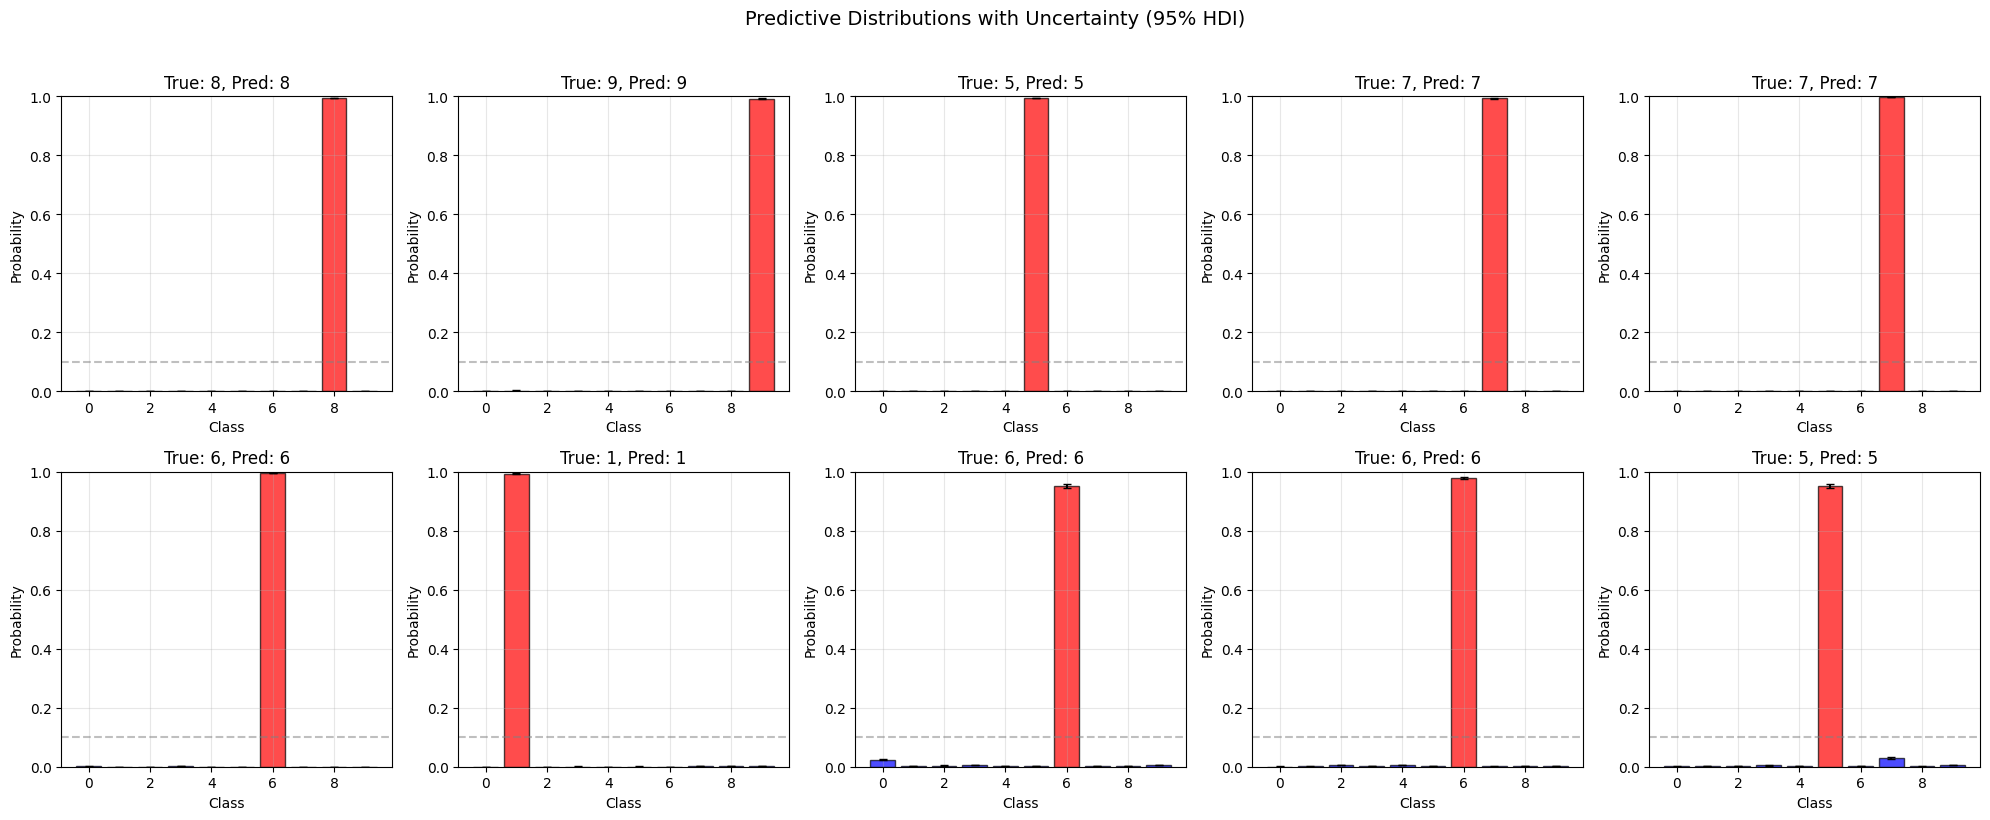

Key observations:
- Error bars show uncertainty in predicted probabilities
- High uncertainty (yellow boxes) indicates unreliable predictions
- This information is unavailable with point estimates (L-BFGS)


In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, idx in enumerate(test_indices):
    probs_dist = predictive_probs_samples[i]
    mean_probs = np.mean(probs_dist, axis=0)
    std_probs = np.std(probs_dist, axis=0)
    
    classes = np.arange(10)
    axes[i].bar(classes, mean_probs, yerr=std_probs, capsize=3, alpha=0.7, edgecolor='black')
    axes[i].set_xticks(classes)
    axes[i].set_ylim([0, 1])
    axes[i].set_title(f'Sample {idx}\nTrue: {labels_test[idx]}', fontsize=10)
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel('Probability')
    axes[i].grid(True, alpha=0.3)
    
    if std_probs.max() > 0.1:
        axes[i].set_facecolor('yellow')
        axes[i].set_alpha(0.3)

plt.tight_layout()
plt.savefig('../latex/figures/predictive_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nKey observations:')
print('- Error bars show uncertainty in predicted probabilities')
print('- High uncertainty (yellow boxes) indicates unreliable predictions')
print('- This information is unavailable with point estimates (L-BFGS)')

In [ ]:
print('='*60)
print('PART 2: SMALL DATASET ANALYSIS')
print('='*60)
print('\nComparing Bayesian vs L-BFGS when validation data is limited')
print('This is where uncertainty quantification matters most!\n')
class TemperatureScaling:
    def __init__(self):
        self.temperature = 1.0

def calibrate_temperature_lbfgs(logits, labels, device, max_iter=1000):
    import torch.nn as nn
    import torch.optim
    logits_torch = torch.tensor(logits, device=device)
    labels_torch = torch.tensor(labels, device=device)
    temperature = nn.Parameter(torch.ones(1, device=device))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.LBFGS([temperature], lr=0.01, max_iter=max_iter)
    def eval():
        optimizer.zero_grad()
        loss = criterion(logits_torch / temperature, labels_torch)
        loss.backward()
        return loss
    optimizer.step(eval)
    return temperature.item()

dataset_sizes = [100, 500, 1000, 5000]
results_small = {}
stan_model_code = """
data {
    int<lower=0> N;
    int<lower=2> K;
    matrix[N, K] logits;
    array[N] int<lower=1, upper=K> y;
    real<lower=0> prior_alpha;
    real<lower=0> prior_beta;
}
parameters {
    real<lower=0> temperature;
}
model {
    temperature ~ gamma(prior_alpha, prior_beta);
    
    for (n in 1:N) {
        vector[K] scaled_logits = logits[n]' / temperature;
        y[n] ~ categorical_logit(scaled_logits);
    }
}
"""
for n_size in dataset_sizes:
    print('='*50)
    print(f'Validation set size: {n_size}')
    print('='*50)
    
    subset_indices = np.random.choice(len(logits_val), n_size, replace=False)
    logits_subset = logits_val[subset_indices]
    labels_subset = labels_val[subset_indices]
    
    if torch.backends.mps.is_available():
        device = torch.device('mps')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    
    temp_lbfgs = calibrate_temperature_lbfgs(logits_subset, labels_subset, device, max_iter=1000)
    print(f'L-BFGS temperature: {temp_lbfgs:.4f} (no uncertainty info)')
    
    prior_alpha = 4.0
    prior_beta = 4.0 / temp_lbfgs
    
    stan_data = {
        'N': logits_subset.shape[0],
        'K': logits_subset.shape[1],
        'logits': logits_subset.tolist(),
        'y': (labels_subset + 1).tolist(),
        'prior_alpha': prior_alpha,
        'prior_beta': prior_beta
    }
    
    print('Running Bayesian MCMC...')
    posterior = stan.build(stan_model_code, data=stan_data)
    fit = posterior.sample(num_chains=4, num_samples=1000, num_warmup=500)
    
    temp_samples = fit['temperature'].flatten()
    mean_temp = np.mean(temp_samples)
    std_temp = np.std(temp_samples)
    hdi_lower = np.percentile(temp_samples, 2.5)
    hdi_upper = np.percentile(temp_samples, 97.5)
    hdi_width = hdi_upper - hdi_lower
    
    results_small[n_size] = {
        'lbfgs': temp_lbfgs,
        'mean': mean_temp,
        'std': std_temp,
        'hdi_lower': hdi_lower,
        'hdi_upper': hdi_upper,
        'hdi_width': hdi_width
    }
    
    print(f'Bayesian: {mean_temp:.4f} ± {std_temp:.4f}')
    print(f'95% HDI: [{hdi_lower:.4f}, {hdi_upper:.4f}], width: {hdi_width:.4f}\n')

PART 2: SMALL DATASET ANALYSIS

Comparing Bayesian vs L-BFGS when validation data is limited
This is where uncertainty quantification matters most!



Using cache found in /Users/Studies/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master



Validation set size: 100
L-BFGS temperature: 0.9999 (no uncertainty info)
Running Bayesian MCMC...
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random 

Bayesian mean: 0.9849 ± 0.2634
95% HDI: [0.5221, 1.5219]
HDI width: 0.9998

Validation set size: 500
L-BFGS temperature: 1.6659 (no uncertainty info)
Running Bayesian MCMC...
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000153 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.53 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000153 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.53 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/var/folders/37/0zy_nm5d0rv5b6vp7z9r6hfh0000gp/T/httpstan_cql83gxp/model_3sngqrs3.stan', line 14, column 4 to colum

Bayesian mean: 1.6656 ± 0.1079
95% HDI: [1.4593, 1.8842]
HDI width: 0.4250

Validation set size: 1000
L-BFGS temperature: 1.7304 (no uncertainty info)
Running Bayesian MCMC...
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   5% (300/6000)
Sampling:  10% (600/6000)
Sampling:  35% (2100/6000)
Sampling:  60% (3600/6000)
Sampling:  80% (4800/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.0003 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/var/folders/37/0zy_nm5d0rv5b6vp7z9r6hfh0000gp/T/httpstan_cql83gxp/model_3sngqrs3.stan', line 14, column 4 to column 49)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, t

Bayesian mean: 1.7307 ± 0.0730
95% HDI: [1.5925, 1.8757]
HDI width: 0.2832

Validation set size: 5000
L-BFGS temperature: 1.7258 (no uncertainty info)
Running Bayesian MCMC...
Building...



Building: found in cache, done.Messages from stanc:
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   0% (4/6000)
Sampling:   2% (103/6000)
Sampling:   3% (202/6000)
Sampling:   5% (301/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1701/6000)
Sampling:  30% (1802/6000)
Sampling:  32% (1903/6000)
Sampling:  33% (2004/6000)
Sampling:  35% (2103/6000)
Sampling:  37% (2202/6000)
Sampling:  38% (2301/6000)
Sampling:  40% (2400/6000)
Sampling:  42% (2500/6000)
Sampling:  43% (2600/6000)
Sampling:  45% (2700/6000)
Samp

Bayesian mean: 1.7285 ± 0.0327
95% HDI: [1.6646, 1.7927]
HDI width: 0.1281

SUMMARY: Uncertainty vs Validation Set Size


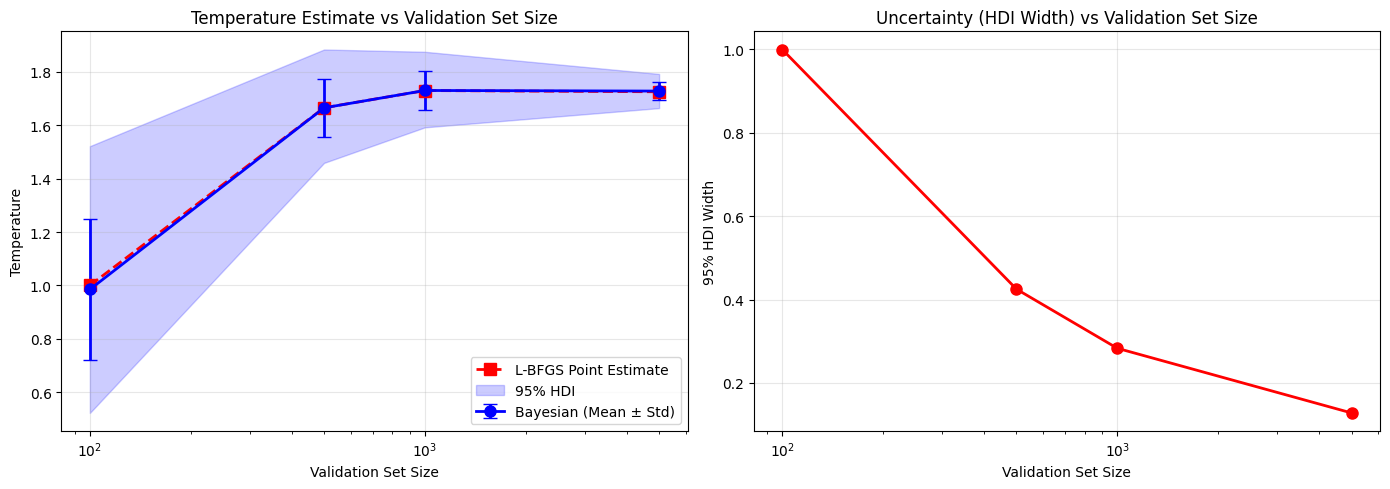


Key Findings:
With n=100:  HDI width = 0.9998 (high uncertainty)
With n=5000: HDI width = 0.1281 (low uncertainty)

Uncertainty reduction: 87.2%

This demonstrates:
- L-BFGS gives same point estimate regardless of data size (no uncertainty info)
- Bayesian approach quantifies uncertainty, which is large when data is limited
- With small datasets, Bayesian credible intervals correctly indicate unreliability
- This is critical for real-world applications where validation data is often scarce!


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

val_sizes_list = sorted(results_small.keys())
lbfgs_temps = [results_small[s]['lbfgs'] for s in val_sizes_list]
bayes_means = [results_small[s]['mean'] for s in val_sizes_list]
bayes_stds = [results_small[s]['std'] for s in val_sizes_list]
hdi_lowers = [results_small[s]['hdi_lower'] for s in val_sizes_list]
hdi_uppers = [results_small[s]['hdi_upper'] for s in val_sizes_list]
hdi_widths = [results_small[s]['hdi_width'] for s in val_sizes_list]

axes[0].errorbar(val_sizes_list, bayes_means, yerr=bayes_stds, fmt='o-', capsize=5, 
                 linewidth=2, markersize=8, label='Bayesian (Mean ± Std)', color='blue')
axes[0].plot(val_sizes_list, lbfgs_temps, 's--', linewidth=2, markersize=8, 
             label='L-BFGS Point Estimate', color='red')
axes[0].fill_between(val_sizes_list, hdi_lowers, hdi_uppers, alpha=0.2, color='blue', label='95% HDI')
axes[0].set_xlabel('Validation Set Size')
axes[0].set_ylabel('Temperature')
axes[0].set_title('Temperature Estimate vs Validation Set Size')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

axes[1].plot(val_sizes_list, hdi_widths, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Validation Set Size')
axes[1].set_ylabel('95% HDI Width')
axes[1].set_title('Uncertainty (HDI Width) vs Validation Set Size')
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

plt.tight_layout()
plt.show()

print('\nKey Findings:')
print(f'With n=100:  HDI width = {results_small[100]["hdi_width"]:.4f} (high uncertainty)')
print(f'With n=5000: HDI width = {results_small[5000]["hdi_width"]:.4f} (low uncertainty)')
print(f'\nUncertainty reduction: {(1 - results_small[5000]["hdi_width"] / results_small[100]["hdi_width"])*100:.1f}%')
print('\nThis demonstrates:')
print('- L-BFGS gives same point estimate regardless of data size (no uncertainty info)')
print('- Bayesian approach quantifies uncertainty, which is large when data is limited')
print('- With small datasets, Bayesian credible intervals correctly indicate unreliability')
print('- This is critical for real-world applications where validation data is often scarce!')


In [7]:
print('='*60)
print('SAVING UNCERTAINTY RESULTS')
print('='*60)

os.makedirs('./data/results', exist_ok=True)

uncertainty_results = {
    'small_dataset_results': results_small,
    'predictive_samples': predictive_probs_samples,
    'test_indices': test_indices
}

np.save('./data/results/uncertainty_results.npy', uncertainty_results, allow_pickle=True)

print('✓ Uncertainty results saved')
print('\nNext step: Run Notebook 5 for Advanced Bayesian Methods')


SAVING UNCERTAINTY RESULTS
✓ Uncertainty results saved

Next step: Run Notebook 5 for Advanced Bayesian Methods
